# Usage: scenario analysis
This is a quick tour of CovsirPhy. Details scenario analysis will be explained.
"Scenario analysis" means that we calculate the number of cases in the future phases with some sets of ODE parameter values. With this analysis, we can estimate the impact of our activities against the outbreak on the number of cases.

### Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.14.0'

### Dataset preparation
Download the datasets to "input" direcotry and load them.  
Please refer to [Usage: datasets](https://lisphilar.github.io/covid19-sir/usage_dataset.html) for the details.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt()

### Start scenario analysis
As an example, we will analysis the number of cases in Japan.

In [5]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot. Some kind of complement will be done for analysis, if necessary.

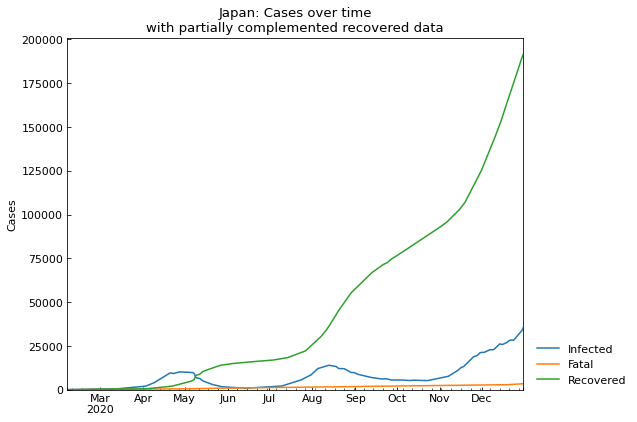

,Date,Infected,Fatal,Recovered
325,2020-12-27,31503,3213,182596
326,2020-12-28,32322,3252,184662
327,2020-12-29,32868,3306,186946
328,2020-12-30,33781,3349,189466
329,2020-12-31,35439,3414,191451


In [6]:
record_df = snl.records()
record_df.tail()

We can calculate the number of daily new cases with `Scenario.record_diff()` method.

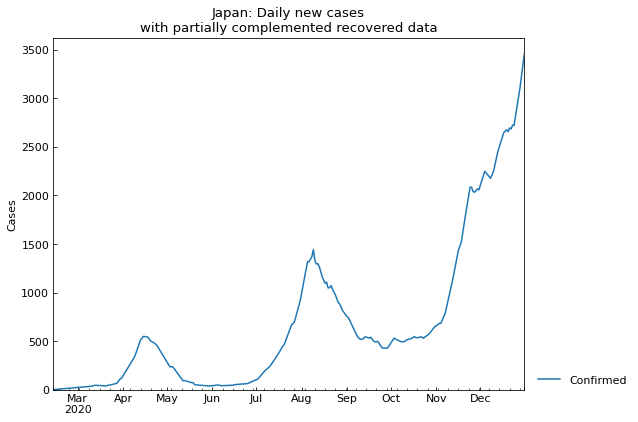

In [7]:
_ = snl.records_diff(variables=["Confirmed"], window=7)

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

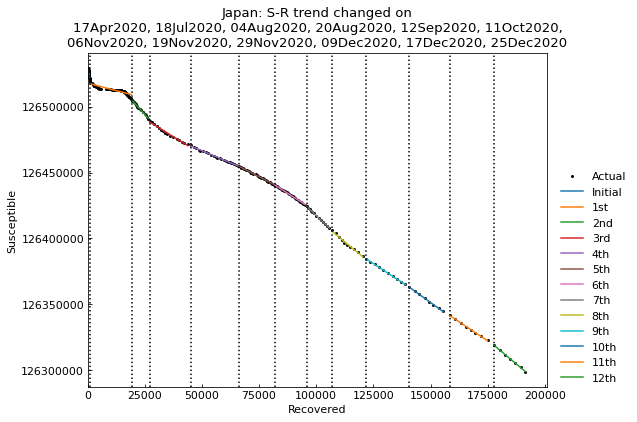

,Type,Start,End,Population
0th,Past,06Feb2020,16Apr2020,126529100
1st,Past,17Apr2020,17Jul2020,126529100
2nd,Past,18Jul2020,03Aug2020,126529100
3rd,Past,04Aug2020,19Aug2020,126529100
4th,Past,20Aug2020,11Sep2020,126529100
5th,Past,12Sep2020,10Oct2020,126529100
6th,Past,11Oct2020,05Nov2020,126529100
7th,Past,06Nov2020,18Nov2020,126529100
8th,Past,19Nov2020,28Nov2020,126529100
9th,Past,29Nov2020,08Dec2020,126529100


In [8]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [9]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 3rd phase (12Sep2020 - 10Oct2020): finished 3047 trials in 3 min  0 sec


	10th phase (17Dec2020 - 24Dec2020): finished  212 trials in 0 min 10 sec

	 1st phase (18Jul2020 - 03Aug2020): finished 2978 trials in 3 min  0 sec

	 0th phase (06Nov2020 - 18Nov2020): finished 2987 trials in 3 min  0 sec

	 2nd phase (19Nov2020 - 28Nov2020): finished 2978 trials in 3 min  0 sec

	 7th phase (06Feb2020 - 16Apr2020): finished 2952 trials in 3 min  0 sec

	 6th phase (20Aug2020 - 11Sep2020): finished  478 trials in 0 min 20 sec

	11th phase (29Nov2020 - 08Dec2020): finished  243 trials in 0 min 10 sec

	 8th phase (09Dec2020 - 16Dec2020): finished  487 trials in 0 min 20 sec

	12th phase (25Dec2020 - 31Dec2020): finished  169 trials in 0 min 10 sec

	 5th phase (11Oct2020 - 05Nov2020): finished  347 trials in 0 min 20 sec

	 4th phase (04Aug2020 - 19Aug2020): finished 1123 trials in 1 min  0 sec

	 9th phase (17Apr2020 - 17Jul2020): finished 2738 trials in 3 min  0 sec

Completed optimization. Total: 9 min  4 sec


In [10]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/gamma [day],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.73,0.018042,0.000230,0.051459,0.010449,720,0.018,2173,47,9,0.258673,2952,3 min 0 sec
1st,Past,17Apr2020,17Jul2020,126529100,SIR-F,0.55,0.044979,0.000938,0.015623,0.026423,720,0.045,533,18,32,0.370772,2738,3 min 0 sec
2nd,Past,18Jul2020,03Aug2020,126529100,SIR-F,1.94,0.000677,0.000113,0.066323,0.034101,720,0.001,4415,14,7,0.018730,2978,3 min 0 sec
3rd,Past,04Aug2020,19Aug2020,126529100,SIR-F,1.17,0.000201,0.000273,0.048422,0.041136,720,0.000,1833,12,10,0.036604,1123,1 min 0 sec
4th,Past,20Aug2020,11Sep2020,126529100,SIR-F,0.76,0.000172,0.000616,0.036358,0.047320,720,0.000,811,10,13,0.023695,478,0 min 20 sec
5th,Past,12Sep2020,10Oct2020,126529100,SIR-F,0.89,0.000182,0.000627,0.046921,0.052040,720,0.000,797,9,10,0.023468,3047,3 min 0 sec
6th,Past,11Oct2020,05Nov2020,126529100,SIR-F,1.09,0.002356,0.000532,0.051630,0.046567,720,0.002,939,10,9,0.050249,347,0 min 20 sec
7th,Past,06Nov2020,18Nov2020,126529100,SIR-F,1.64,0.000269,0.000403,0.068347,0.041357,720,0.000,1241,12,7,0.009748,2987,3 min 0 sec
8th,Past,19Nov2020,28Nov2020,126529100,SIR-F,1.52,0.000937,0.000403,0.063781,0.041452,720,0.001,1240,12,7,0.025500,2978,3 min 0 sec
9th,Past,29Nov2020,08Dec2020,126529100,SIR-F,1.11,0.000349,0.000709,0.049333,0.043677,720,0.000,705,11,10,0.008225,243,0 min 10 sec


### Accuracy of estimation

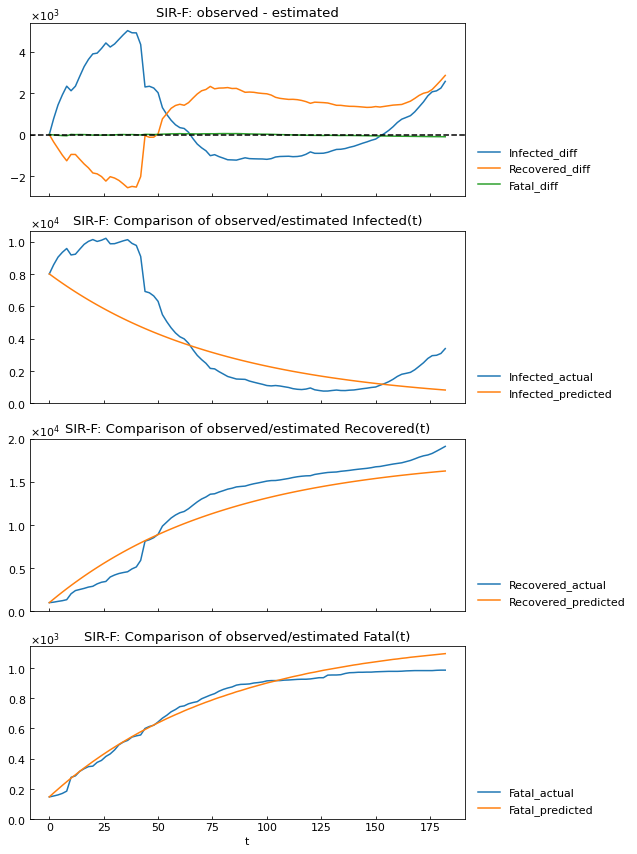

In [11]:
snl.estimate_accuracy(phase="1st")

### Get parameter value
We can get the parameter values of a phase using `Scenario.get()` method.

In [12]:
snl.get("Rt", phase="4th")

0.76

### Show parameter history
`Scenario.history()` method shows the trajectories of parameters (and the number of cases).

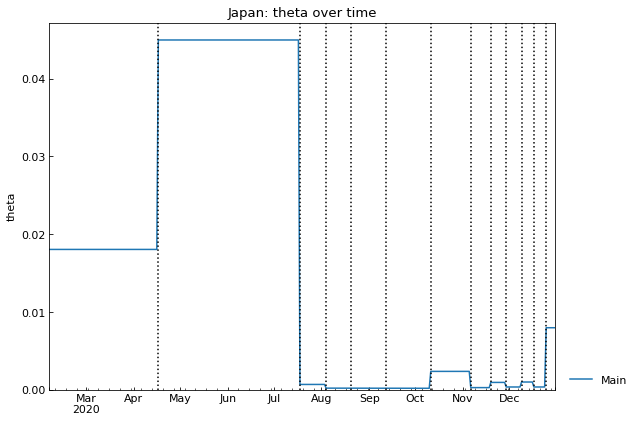

In [13]:
_ = snl.history(target="theta")

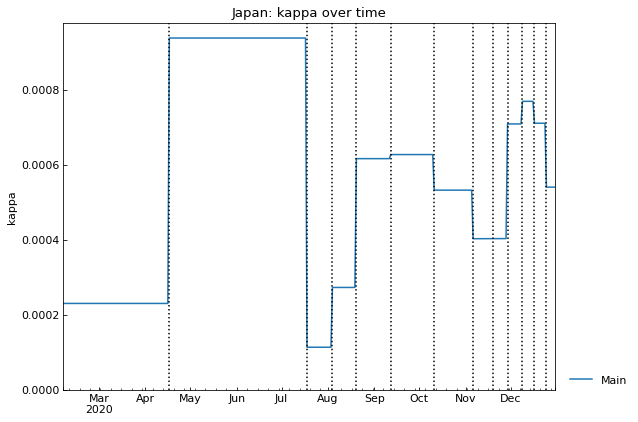

In [14]:
_ = snl.history(target="kappa")

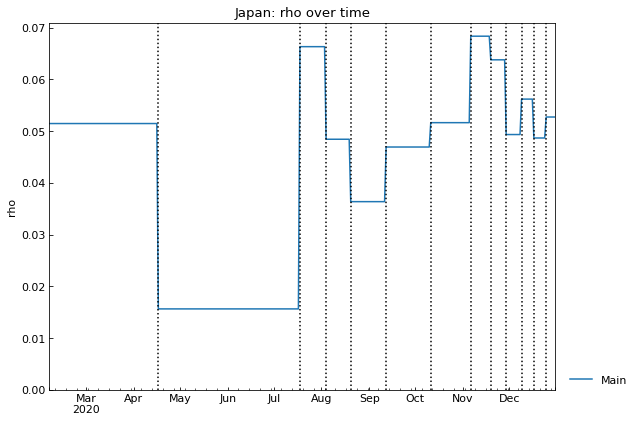

In [15]:
_ = snl.history(target="rho")

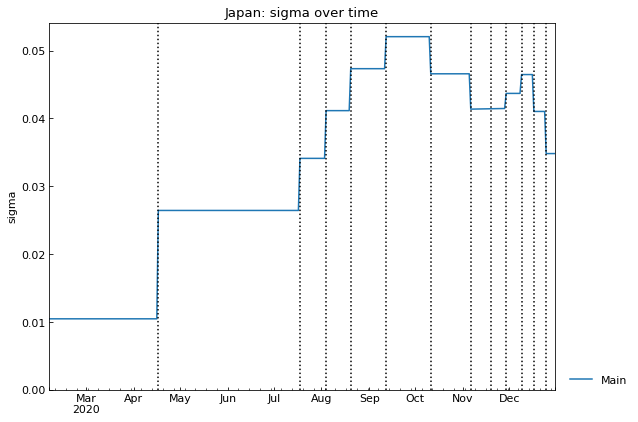

In [16]:
_ = snl.history(target="sigma")

Notes on the history of $\sigma$ value in japan (last updated: 28Dec2020):  
In Japan, we experienced two waves and we are in third wave. In the first wave (Apr - May), recovery period was too long because collapse of the medical care system occurred and no medicines were found.

Sigma values: the first wave < the second wave > the third wave

However, in the second wave (Jul - Oct), recovery period appears short because we have some effective medicines (not approved, in clinical study), yonger people (people un-associated to sever diseases) were infected.

In the third wave (Nov - ), older people tend to be infected and we are facing with medical collapse at this time...

### Show the history of reproduction number
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)). When this value is larger than 1, the infection disease is outbreaking.

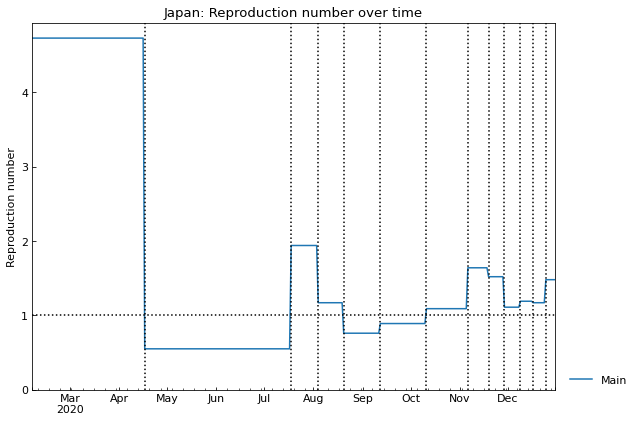

In [17]:
_ = snl.history(target="Rt")

### Simulate the number of cases
We can compare the actual and simulated (with estimated parameter values) number of confirmed/infected/recovered/fatal cases using `Scenario.history()` method.

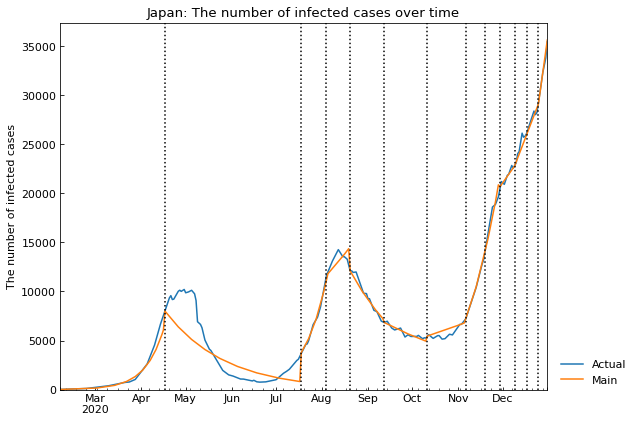

In [18]:
_ = snl.history("Infected")

### Main scenario
If the parameter velues will not be changed until 01Apr2021, how many cases will be? We call this scenario as "Main" scenario.

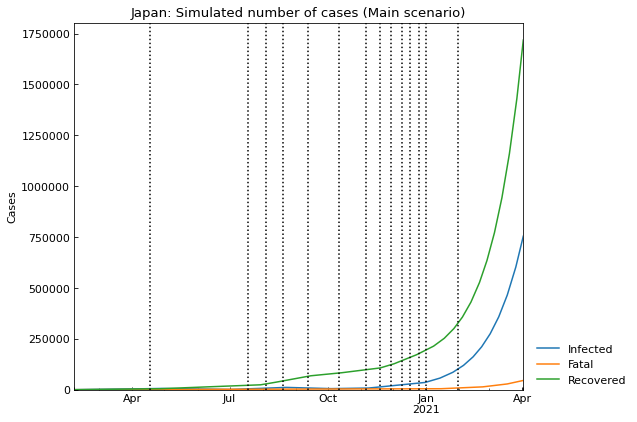

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,2224654,40006,663795,1520853
418,2021-03-30,2294509,41292,685406,1567811
419,2021-03-31,2366596,42619,707680,1616297
420,2021-04-01,2440978,43988,730633,1666357
421,2021-04-02,2517726,45402,754284,1718040


In [19]:
# Clear future phases in Main scenario
snl.clear(name="Main")
# Add one future phase 30 days with the parameter set of the last past phase
snl.add(days=30)
# Add one future phase until 01Apr2021 with the same parameter set
snl.add(end_date="01Apr2021", name="Main")
# Simulate the number of cases
snl.simulate(name="Main").tail()

### Medicine scenario
If $\sigma$ will be double in 30 days, how many cases will be? We will call this scenario as "Medicine" scenario.

In [20]:
# Calcuate the current sigma value of the last phase
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.03480743563360632

In [21]:
# Sigma value will be double
sigma_new = sigma_current * 2
sigma_new

0.06961487126721264

In [22]:
# Initialize "Medicine" scenario (with the same past phases as that of Main scenario)
snl.clear(name="Medicine")
# Add 30 days as a new future phases with the same parameter set
snl.add(name="Medicine", days=30, sigma=sigma_current)
# Add a phase until 01Apr2021 with doubled sigma value
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary(name="Medicine")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/gamma [day],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.73,0.018042,0.000230,0.051459,0.010449,720,0.018,2173,47,9,0.258673,2952,3 min 0 sec
1st,Past,17Apr2020,17Jul2020,126529100,SIR-F,0.55,0.044979,0.000938,0.015623,0.026423,720,0.045,533,18,32,0.370772,2738,3 min 0 sec
2nd,Past,18Jul2020,03Aug2020,126529100,SIR-F,1.94,0.000677,0.000113,0.066323,0.034101,720,0.001,4415,14,7,0.0187295,2978,3 min 0 sec
3rd,Past,04Aug2020,19Aug2020,126529100,SIR-F,1.17,0.000201,0.000273,0.048422,0.041136,720,0.000,1833,12,10,0.0366036,1123,1 min 0 sec
4th,Past,20Aug2020,11Sep2020,126529100,SIR-F,0.76,0.000172,0.000616,0.036358,0.047320,720,0.000,811,10,13,0.0236953,478,0 min 20 sec
5th,Past,12Sep2020,10Oct2020,126529100,SIR-F,0.89,0.000182,0.000627,0.046921,0.052040,720,0.000,797,9,10,0.0234685,3047,3 min 0 sec
6th,Past,11Oct2020,05Nov2020,126529100,SIR-F,1.09,0.002356,0.000532,0.051630,0.046567,720,0.002,939,10,9,0.050249,347,0 min 20 sec
7th,Past,06Nov2020,18Nov2020,126529100,SIR-F,1.64,0.000269,0.000403,0.068347,0.041357,720,0.000,1241,12,7,0.00974844,2987,3 min 0 sec
8th,Past,19Nov2020,28Nov2020,126529100,SIR-F,1.52,0.000937,0.000403,0.063781,0.041452,720,0.001,1240,12,7,0.0254999,2978,3 min 0 sec
9th,Past,29Nov2020,08Dec2020,126529100,SIR-F,1.11,0.000349,0.000709,0.049333,0.043677,720,0.000,705,11,10,0.00822479,243,0 min 10 sec


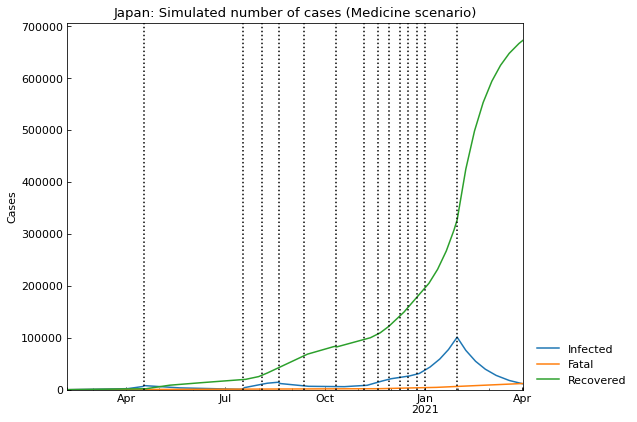

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,690877,11883,12842,666152
418,2021-03-30,692198,11907,12385,667906
419,2021-03-31,693471,11930,11944,669597
420,2021-04-01,694700,11953,11519,671228
421,2021-04-02,695886,11974,11109,672803


In [23]:
# Simulate the number of cases
snl.simulate(name="Medicine").tail()

### Short-term prediction of parameter values
With OxCGRT data, we can predict the parameter values of the future phases because [OxCGRT indicators](https://github.com/OxCGRT/covid-policy-tracker) (policy measures) impact on parameter values with delay (=recovery period).  

OxCGRT indicators are

- school_closing,
- workplace_closing,
- cancel_events, 
- gatherings_restrictions,
- transport_closing,
- stay_home_restrictions,
- internal_movement_restrictions,
- international_movement_restrictions,
- information_campaigns,
- testing_policy, and
- contact_tracing.

In [24]:
# Fitting with linear regression model (Elastic Net regression)
fit_dict = snl.fit(oxcgrt_data=oxcgrt_data, name="Forecast")
print(f"Determination coefficient: {fit_dict['score_train']} (train)")
print(f"Determination coefficient: {fit_dict['score_test']} (test)")
print("Intercept:")
fit_dict["intercept"].style.background_gradient(axis=None)

Determination coefficient: 0.6905606273620326 (train)
Determination coefficient: 0.7609662739889309 (test)
Intercept:


,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing
theta,0.008712,0.012124,-0.012993,0.000000,0.009292,0.016417,0.012124,0.005229,-0.003433,-0.047413,0.036599
kappa,-0.000001,0.000255,-0.000290,0.000000,-0.000166,0.000551,0.000255,0.000012,0.000006,-0.000518,0.000784
rho,-0.004692,-0.015079,0.016421,0.000000,-0.004677,-0.024357,-0.015079,-0.004981,0.003048,0.039045,-0.030393
sigma,-0.008912,0.003830,-0.004977,0.000000,-0.009829,0.016376,0.003830,-0.003419,0.002986,0.019559,-0.013672


In [25]:
# Short-term prediction
snl.predict(name="Forecast").summary(name="Forecast")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/gamma [day],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,16Apr2020,126529100,SIR-F,4.73,0.018042,0.000230,0.051459,0.010449,720,0.018,2173,47,9,0.258673,2952,3 min 0 sec
1st,Past,17Apr2020,17Jul2020,126529100,SIR-F,0.55,0.044979,0.000938,0.015623,0.026423,720,0.045,533,18,32,0.370772,2738,3 min 0 sec
2nd,Past,18Jul2020,03Aug2020,126529100,SIR-F,1.94,0.000677,0.000113,0.066323,0.034101,720,0.001,4415,14,7,0.0187295,2978,3 min 0 sec
3rd,Past,04Aug2020,19Aug2020,126529100,SIR-F,1.17,0.000201,0.000273,0.048422,0.041136,720,0.000,1833,12,10,0.0366036,1123,1 min 0 sec
4th,Past,20Aug2020,11Sep2020,126529100,SIR-F,0.76,0.000172,0.000616,0.036358,0.047320,720,0.000,811,10,13,0.0236953,478,0 min 20 sec
5th,Past,12Sep2020,10Oct2020,126529100,SIR-F,0.89,0.000182,0.000627,0.046921,0.052040,720,0.000,797,9,10,0.0234685,3047,3 min 0 sec
6th,Past,11Oct2020,05Nov2020,126529100,SIR-F,1.09,0.002356,0.000532,0.051630,0.046567,720,0.002,939,10,9,0.050249,347,0 min 20 sec
7th,Past,06Nov2020,18Nov2020,126529100,SIR-F,1.64,0.000269,0.000403,0.068347,0.041357,720,0.000,1241,12,7,0.00974844,2987,3 min 0 sec
8th,Past,19Nov2020,28Nov2020,126529100,SIR-F,1.52,0.000937,0.000403,0.063781,0.041452,720,0.001,1240,12,7,0.0254999,2978,3 min 0 sec
9th,Past,29Nov2020,08Dec2020,126529100,SIR-F,1.11,0.000349,0.000709,0.049333,0.043677,720,0.000,705,11,10,0.00822479,243,0 min 10 sec


In [26]:
# Or, when you do not need 'fit_dict'
# snl.fit_predict(oxcgrt_data=oxcgrt_data, name="Forecast").summary(name="Forecast")

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [27]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,Confirmed on 18Jan2021,Infected on 18Jan2021,Fatal on 18Jan2021,13th_Rt,14th_Rt
Main,754284,02Apr2021,2517726.0,754284.0,45402.0,NaN,NaN,NaN,1.48,1.48
Medicine,101038,31Jan2021,695886.0,11109.0,11974.0,NaN,NaN,NaN,1.48,0.75
Forecast,57506,18Jan2021,NaN,NaN,NaN,314485.0,57506.0,4968.0,1.35,-


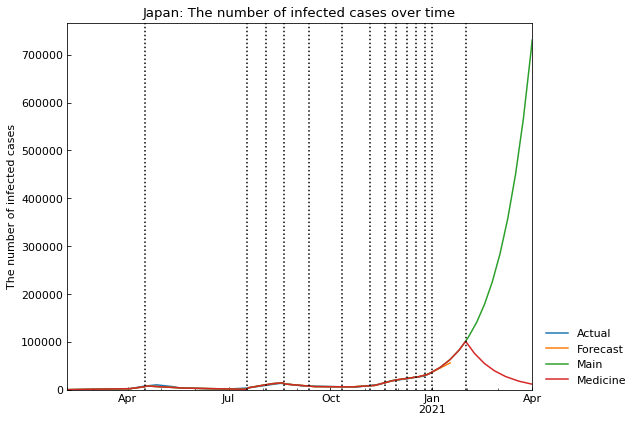

In [28]:
_ = snl.history(target="Infected")

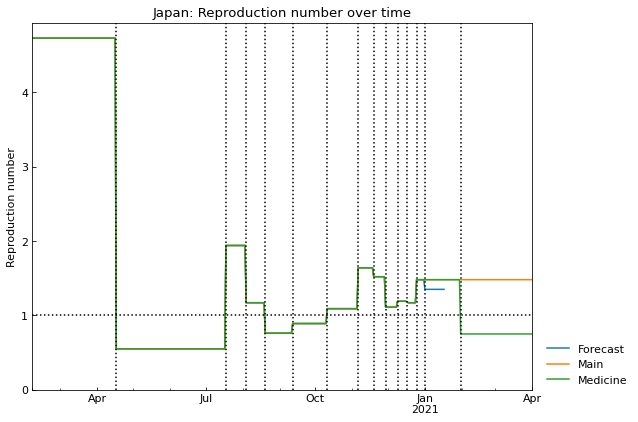

In [29]:
_ = snl.history(target="Rt")

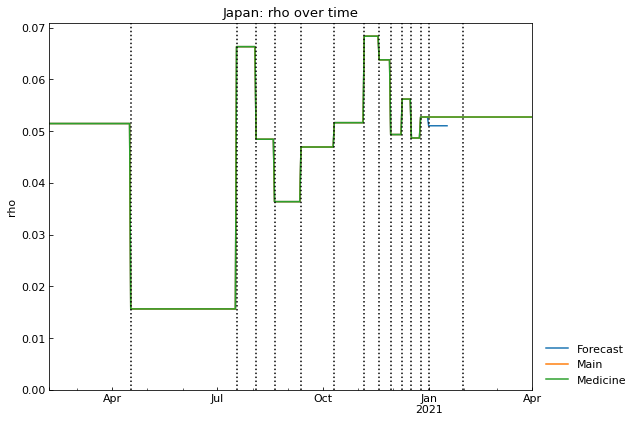

In [30]:
_ = snl.history(target="rho")

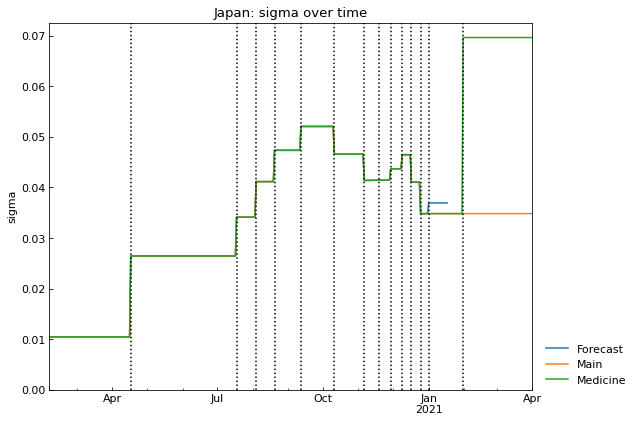

In [31]:
_ = snl.history(target="sigma")

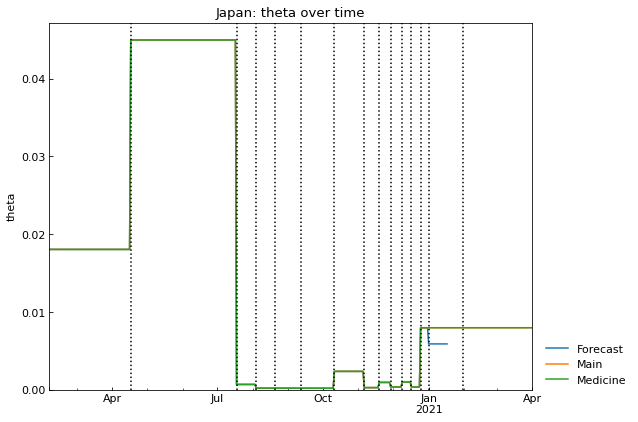

In [32]:
_ = snl.history(target="theta")

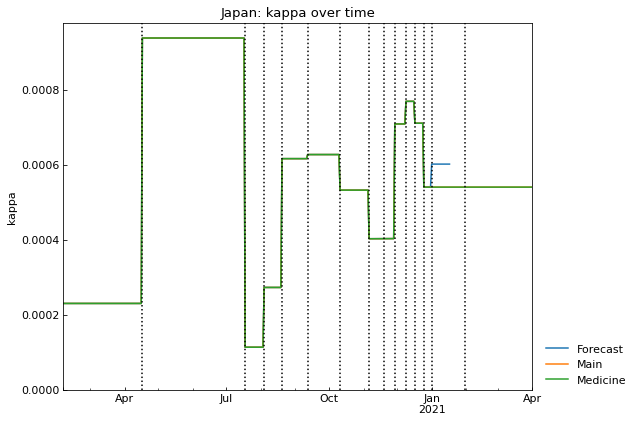

In [33]:
_ = snl.history(target="kappa")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

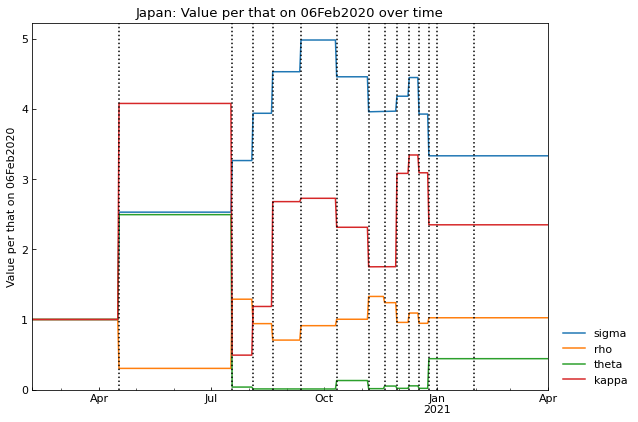

In [34]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [35]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 3rd phase (12Sep2020 - 10Oct2020): finished 2411 trials in 3 min  1 sec


	 0th phase (01Sep2020 - 11Sep2020): finished  227 trials in 0 min 10 sec

	 2nd phase (17Dec2020 - 24Dec2020): finished  228 trials in 0 min 10 sec

	 7th phase (20Aug2020 - 31Aug2020): finished  237 trials in 0 min 10 sec

	 1st phase (18Jul2020 - 03Aug2020): finished 2667 trials in 3 min  0 sec

	10th phase (06Nov2020 - 18Nov2020): finished 2658 trials in 3 min  0 sec

	 6th phase (06Feb2020 - 16Apr2020): finished 2630 trials in 3 min  1 sec

	 4th phase (19Nov2020 - 28Nov2020): finished 2644 trials in 3 min  0 sec

	12th phase (29Nov2020 - 08Dec2020): finished  219 trials in 0 min 10 sec

	11th phase (09Dec2020 - 16Dec2020): finished  604 trials in 0 min 30 sec

	13th phase (25Dec2020 - 31Dec2020): finished  219 trials in 0 min 10 sec

	 5th phase (11Oct2020 - 05Nov2020): finished  230 trials in 0 min 10 sec

	 9th phase (04Aug2020 - 19Aug2020): finished 1140 trials in 1 min  0 sec

	 8th phase (17Apr2020 - 17Jul2020): finished 2912 trials in 3 min  0 sec

Completed optimization. Total: 9 min  4 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 3rd phase (01Sep2020 - 31Dec2020): finished 8748 trials in 3 min  0 sec

Completed optimization. Total: 3 min  0 sec


In [36]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  16Apr2020  SIR-F  4.73  0.016776  0.000335   
              1st    17Apr2020  17Jul2020  SIR-F  0.55  0.044979  0.000938   
              2nd    18Jul2020  03Aug2020  SIR-F  1.88  0.000086  0.000144   
              3rd    04Aug2020  19Aug2020  SIR-F  1.17  0.000201  0.000273   
              4th    20Aug2020  31Aug2020  SIR-F  0.68  0.001113  0.000531   
              5th    01Sep2020  11Sep2020  SIR-F  0.68  0.000354  0.000710   
              6th    12Sep2020  10Oct2020  SIR-F  0.89  0.000182  0.000627   
              7th    11Oct2020  05Nov2020  SIR-F  1.09  0.002356  0.000532   
              8th    06Nov2020  18Nov2020  SIR-F  1.64  0.000269  0.000403   
              9th    19Nov2020  28Nov2020  SIR-F  1.52  0.000937  0.000403   
              10th   29Nov2020  08Dec2020  SIR-F  1.11  0.000349  0.000709   
              11th   09Dec2020  16Dec2020  SIR-F  1.25  0.000323  0.000851   
              12th   17Dec2020  24Dec2020  SIR-F  1.17  0.000349  0.000711   
              13th   25Dec2020  31Dec2020  SIR-F  1.48  0.000350  0.000711   
Retrospective 0th    06Feb2020  16Apr2020  SIR-F  4.73  0.016776  0.000335   
              1st    17Apr2020  17Jul2020  SIR-F  0.55  0.044979  0.000938   
              2nd    18Jul2020  03Aug2020  SIR-F  1.88  0.000086  0.000144   
              3rd    04Aug2020  19Aug2020  SIR-F  1.17  0.000201  0.000273   
              4th    20Aug2020  31Aug2020  SIR-F  0.68  0.001113  0.000531   
              5th    01Sep2020  31Dec2020  SIR-F  0.68  0.001113  0.000531   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.051836  0.010442  0.258962    2630  3 min  1 sec  
              1st    0.015623  0.026423  0.370772    2912  3 min  0 sec  
              2nd    0.068549  0.036254  0.019387    2667  3 min  0 sec  
              3rd    0.048422  0.041136  0.036604    1140  1 min  0 sec  
              4th    0.034508  0.050184  0.055859     237  0 min 10 sec  
              5th    0.034064  0.049696  0.013040     227  0 min 10 sec  
              6th    0.046921  0.052040  0.023468    2411  3 min  1 sec  
              7th    0.051630  0.046567  0.050249     230  0 min 10 sec  
              8th    0.068347  0.041357  0.009748    2658  3 min  0 sec  
              9th    0.063781  0.041452  0.025500    2644  3 min  0 sec  
              10th   0.049333  0.043677  0.008225     219  0 min 10 sec  
              11th   0.055194  0.043238  0.011320     604  0 min 30 sec  
              12th   0.048666  0.041018  0.008526     228  0 min 10 sec  
              13th   0.052897  0.034935  0.007248     219  0 min 10 sec  
Retrospective 0th    0.051836  0.010442  0.258962    2630  3 min  1 sec  
              1st    0.015623  0.026423  0.370772    2912  3 min  0 sec  
              2nd    0.068549  0.036254  0.019387    2667  3 min  0 sec  
              3rd    0.048422  0.041136  0.036604    1140  1 min  0 sec  
              4th    0.034508  0.050184  0.055859     237  0 min 10 sec  
              5th    0.034508  0.050184  1.579280    8748  3 min  0 sec

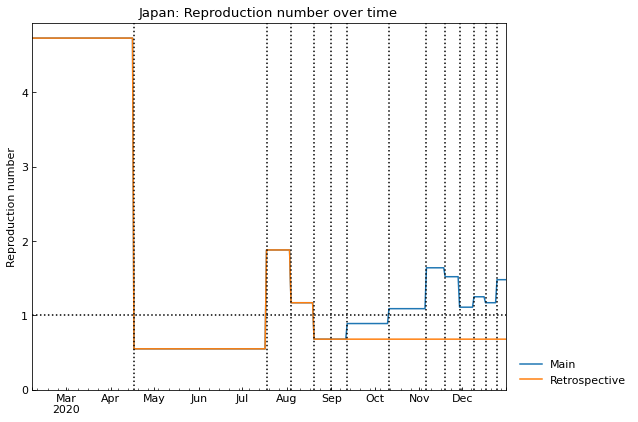

In [37]:
# History of reproduction number
_ = snl_retro.history("Rt")

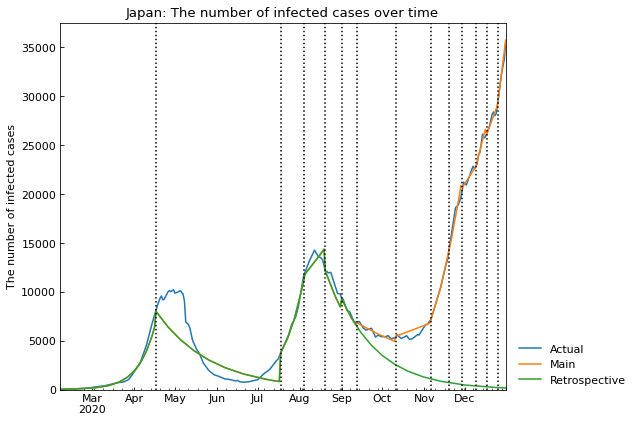

In [38]:
# History of Infected
_ = snl_retro.history("Infected")

In [39]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 01Jan2021,Infected on 01Jan2021,Fatal on 01Jan2021,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt,13th_Rt
Main,36969,01Jan2021,234279,36969,3441,0.89,1.09,1.64,1.52,1.11,1.25,1.17,1.48
Retrospective,14360,19Aug2020,87678,176,1614,-,-,-,-,-,-,-,-
